# Tappy Keystroke Data with Parkinson’s Patients

Tappy è un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

Al dataset è associato un articolo preso dal sito https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188226#sec008, in cui viene spiegato il significato degli attributi. Da questo paper abbiamo tratto informazioni utili per l'acquisizione dei dati.

## Indice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime

## Caricamento dataset

In [2]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

In [26]:
all_userdata_df.head(10)

,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Flight,*,BirthYear,...,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
0,0EA27ICBLF,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
1,0EA27ICBLF,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
2,0EA27ICBLF,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
3,0EA27ICBLF,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
4,0EA27ICBLF,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
5,0EA27ICBLF,160722,18:42:15.766,L,0078.1,SL,0226.6,0101.6,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
6,0EA27ICBLF,160722,18:42:15.969,R,0085.9,LR,0195.3,0117.2,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
7,0EA27ICBLF,160722,18:42:16.875,R,0085.9,RR,0359.4,0296.9,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
8,0EA27ICBLF,160722,18:42:17.289,L,0070.3,RL,0429.7,0343.8,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False
9,0EA27ICBLF,160722,18:42:17.727,L,0101.6,LL,0406.3,0335.9,,1952,...,True,True,2000,Left,Don't know,Severe,True,True,False,False


## Pulizia dataset

Tra i pazienti con il morbo di Parkinson consideriamo solo quelli nelle prime fasi della malattia. Per questo si mantengono solo i pazienti con impatto lieve, oltre a quelli non malati.

Sempre facendo fede all'articolo di riferimento, sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa.

Inoltre sono stati rimossi i pazienti di cui sono stati analizzati troppi o troppi pochi dati, con lo scopo di avere un insieme di dati più consistente e bilanciato.

Dopo la pulizia di questi attributi, sono state cancellate le colonne ritenute meno utili per l'addestramento.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e fortemente correlato alla positività al morbo di Parkinson.

In [3]:
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # numero medio di tap per ogni utente

all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

#all_userdata_df = all_userdata_df.drop(["Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)
all_userdata_df = all_userdata_df.drop(["Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in termini di eta

(array([28.,  8.,  2.,  2.,  6.,  2.,  3.,  2.,  0.,  1.]),
 array([  1000.,  10900.,  20800.,  30700.,  40600.,  50500.,  60400.,
         70300.,  80200.,  90100., 100000.]),
 <BarContainer object of 10 artists>)

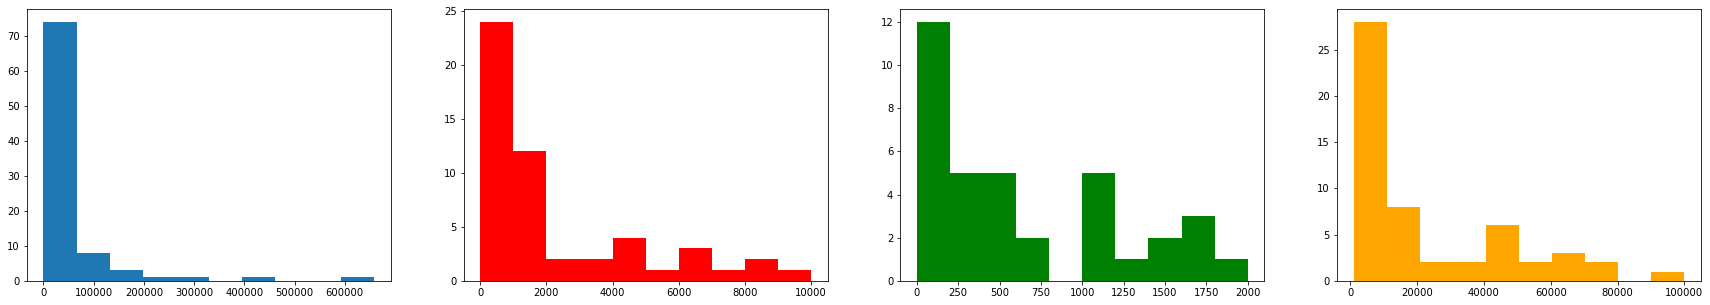

In [33]:
fig, axs = plt.subplots(1, 4, figsize = (30,5))
axs[0].hist(counts)
axs[1].hist(counts, range = [0, 10000], color = "red")
axs[2].hist(counts, range = [0, 2000], color = "green")
axs[3].hist(counts, range = [1000, 100000], color = "orange") # area of interest

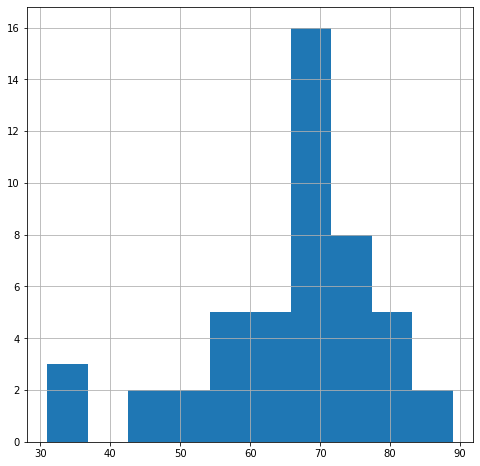

In [40]:
all_userdata_df.Age.hist(figsize=(8,8))
plt.show()

In [4]:
all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

In [5]:
hold_z_scores = stats.zscore(all_userdata_df["Hold"])
abs_z_scores = np.abs(hold_z_scores)

filtered_entries = (abs_z_scores < 3)

all_userdata_df = all_userdata_df[filtered_entries]

#################

lat_z_scores = stats.zscore(all_userdata_df["Latency"])
abs_z_scores = np.abs(lat_z_scores)

filtered_entries2 = (abs_z_scores < 3)

all_userdata_df = all_userdata_df[filtered_entries2]


In [5]:
all_userdata_df.head(10)
#all_userdata_df.info()

,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,160916,19:20:43.891,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,160916,19:20:44.344,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,160916,19:20:44.742,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,160916,19:20:45.516,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,160916,19:20:46.047,R,101.6,LR,523.4,58,0,0
158458,0QAZFRHQHW,160916,19:20:46.242,R,93.8,RR,203.1,58,0,0
158459,0QAZFRHQHW,160918,10:35:01.508,L,109.4,RL,289.1,58,0,0
158460,0QAZFRHQHW,160918,10:35:01.930,R,214.8,LR,316.4,58,0,0
158461,0QAZFRHQHW,160918,10:35:02.164,R,66.4,RR,382.8,58,0,0
158462,0QAZFRHQHW,160918,10:44:58.918,L,93.8,RL,562.5,58,0,0


In [6]:


all_userdata_df.Date = all_userdata_df.Date.astype(str)
all_userdata_df.Datetime = all_userdata_df.Datetime.astype(str)
#all_userdata_df.head(10)

array_app = []

for i in range(len(all_userdata_df)):

    elem = all_userdata_df.iloc[i].Datetime[0:8]
    elem1 =all_userdata_df.iloc[i].Date
    elem_time = datetime.strptime(elem1+" " +elem, '%d%m%y %H:%M:%S')
    array_app.append(elem_time)

In [7]:

pipo = pd.DataFrame(array_app,columns=['Date'])
pipo.head()

,Date
0,2016-09-16 19:20:43
1,2016-09-16 19:20:44
2,2016-09-16 19:20:44
3,2016-09-16 19:20:46
4,2016-09-16 19:20:46


In [8]:
all_userdata_df = all_userdata_df.drop(columns=["Date","Datetime"])
all_userdata_df_v2 = pd.concat([all_userdata_df, pipo], axis=1)

all_userdata_df_v2.head(10)

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons,Date
158453,0QAZFRHQHW,L,78.1,LL,312.5,58.0,Female,False,2027-07-16 08:13:31
158454,0QAZFRHQHW,L,78.1,LL,453.1,58.0,Female,False,2027-07-16 08:13:31
158455,0QAZFRHQHW,L,62.5,LL,414.1,58.0,Female,False,2027-07-16 08:13:31
158457,0QAZFRHQHW,R,101.6,LR,523.4,58.0,Female,False,2027-07-16 08:13:31
158458,0QAZFRHQHW,R,93.8,RR,203.1,58.0,Female,False,2027-07-16 08:13:31
158459,0QAZFRHQHW,L,109.4,RL,289.1,58.0,Female,False,2027-07-16 08:13:32
158460,0QAZFRHQHW,R,214.8,LR,316.4,58.0,Female,False,2027-07-16 08:13:33
158461,0QAZFRHQHW,R,66.4,RR,382.8,58.0,Female,False,2027-07-16 08:13:33
158462,0QAZFRHQHW,L,93.8,RL,562.5,58.0,Female,False,2027-07-16 08:13:34
158463,0QAZFRHQHW,R,187.5,RR,453.1,58.0,Female,False,2027-07-16 08:13:34


In [9]:
all_userdata_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959610 entries, 158453 to 1039459
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Users        object        
 1   TapPosition  object        
 2   Hold         float64       
 3   Movement     object        
 4   Latency      float64       
 5   Age          float64       
 6   Gender       object        
 7   Parkinsons   object        
 8   Date         datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 149.5+ MB


In [10]:
#all_userdata_df.Age = all_userdata_df.Age.astype(str)
#all_userdata_df.Gender = all_userdata_df.Gender.astype(str)
#all_userdata_df_v2.info()

#all_userdata_df_v2.Age = all_userdata_df_v2.Age.astype(int)
#all_userdata_df_v2.Hold = all_userdata_df_v2.Hold.astype(float)

#all_userdata_df_v2.Latency = all_userdata_df_v2.Latency.astype(float)

all_userdata_df_v2.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df_v2.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
all_userdata_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959610 entries, 158453 to 1039459
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Users        object        
 1   TapPosition  object        
 2   Hold         float64       
 3   Movement     object        
 4   Latency      float64       
 5   Age          float64       
 6   Gender       float64       
 7   Parkinsons   float64       
 8   Date         datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 149.5+ MB


In [12]:
all_userdata_df_v2.head()
all_userdata_df_v2.iloc[0:2,1]

158453    L
158454    L
Name: TapPosition, dtype: object

In [11]:
"""
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values
"""

g = len(all_userdata_df)
current_user = all_userdata_df_v2.iloc[0,0]         #parto dalla prima posizione
#print(current_user)
list_users = all_userdata_df_v2.Users.unique()
len_lu =len(list_users) #ultimo elemento di list_users è nan

data_list = []

for j in range(len_lu-1):
    #print(j)
    set = all_userdata_df_v2[all_userdata_df_v2['Users'] == list_users[j]]      #sottodataframe con righe corrispondenti allo user j
    rif_row = set.iloc[0,:]                 #prima riga dell'utente j
    ind_row = 0                             #indice di riga di riferimento dell'utente j
    #print(rif_row[-1])

    for k in range(len(set)):               #scorro righe dell'utente j
        current_row = set.iloc[k,:]
        time2 = current_row[-1]             #data (ultima colonna) della riga corrente
        time1 = rif_row[-1]
        diff_time = (time2 - time1).total_seconds()
        #print(diff_time)

        if(diff_time >= 90):  # or sulla fine delle digit ??
        # k mi da numero di digit nella serie, se volessi avere un num min metto controllo
            mini_df = set.iloc[ind_row:k-1,:]
            #mini_df.head()
            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  
            # QUA DEVO CALCOLARE MEDIA E VAR ECC DELLA SERIA DI DIGIT -> fare come altra versione per le medie ecc
            
            hold_by_user =  mini_df[mini_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
            hold_by_user_flat = hold_by_user.unstack()
            hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
            #hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']

            latency_by_user = mini_df[np.isin(mini_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
            latency_by_user_flat = latency_by_user.unstack()
            latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
            #latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
            #latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']

            combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)

            if (len(combined_df.values) != 0 ):
                #data_list.append(combined_df.values.tolist()[0])
                data_list.append(combined_df.reset_index(level=0).values.tolist()[0])

            # hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
            # da sistemare

            # inserire questa riga in un nuovo dataframe o lista su cui poi faccio database

            # fare lo stesso con latenze RL LR ecc..

            # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            ind_row = k
            rif_row = set.iloc[ind_row,:]
            # attenzione con questo > 90 potrei buttare ultima time serie 
    


print(len(data_list))

c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1216: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\scipy\stats\stats.py:1107: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
c:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: inval

845


In [12]:
column_names = ['Users','mean_L','mean_R','std_L','std_R','skew_L','skew_R','kurtosis_L','kurtosis_R','mean_LL','mean_LR','mean_RL','mean_RR','std_LL','std_LR','std_RL','std_RR','skew_LL','skew_LR','skew_RL','skew_RR','kustosis_LL','kurtosis_LR','kurtosis_RL','kurtosis_RR']
#print(data_list[0:10])

pandino = pd.DataFrame(data_list, columns = column_names)
pandino.head(10)
#pandino.shape

pan = pandino.fillna(0)
pan.head(10)


,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR
0,0QAZFRHQHW,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,...,114.108660,163.599360,0.008643,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129
1,0QAZFRHQHW,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,...,139.543395,109.202775,-0.230768,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242
2,0QAZFRHQHW,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,...,110.530190,136.773129,0.889206,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680
3,0QAZFRHQHW,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,...,115.772987,126.048792,0.752484,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758
4,0QAZFRHQHW,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,...,181.773109,106.455900,0.901527,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310
5,0QAZFRHQHW,95.923684,94.400000,19.371160,24.026743,-0.552363,1.344739,1.577232,1.436836,360.160000,...,120.572572,104.493026,0.308167,0.590916,0.078188,0.515105,-1.213377,-0.580734,-1.177608,-0.074588
6,0QAZFRHQHW,102.768831,103.320690,29.878452,26.189075,-0.042985,1.186240,0.344357,2.534803,444.979412,...,149.082326,143.668950,-0.052408,-0.586051,-0.152044,0.576361,-1.069450,-0.263898,-1.573124,-0.703352
7,0QAZFRHQHW,79.660000,95.985714,6.525948,16.722782,-0.343622,0.261459,-1.153061,-1.455689,454.700000,...,0.243040,-0.665608,-0.166620,-1.550577,-1.500000,-1.100801,0.000000,0.000000,0.000000,0.000000
8,0QAZFRHQHW,103.958065,101.996000,21.975908,25.313382,0.210961,0.359783,-0.929172,-0.085760,418.872727,...,92.619828,111.834498,-0.230037,-0.844857,-0.917347,0.152074,-0.427746,-0.173139,0.266506,-1.460761
9,0QAZFRHQHW,93.170370,120.400000,25.702571,119.532802,0.538108,4.416360,0.454343,18.406848,396.395000,...,127.196429,135.702478,-0.018905,-0.292177,1.109689,0.220980,-0.502630,-1.662293,0.184948,-1.009162


In [13]:
pan.isna().sum()

Users          0
mean_L         0
mean_R         0
std_L          0
std_R          0
skew_L         0
skew_R         0
kurtosis_L     0
kurtosis_R     0
mean_LL        0
mean_LR        0
mean_RL        0
mean_RR        0
std_LL         0
std_LR         0
std_RL         0
std_RR         0
skew_LL        0
skew_LR        0
skew_RL        0
skew_RR        0
kustosis_LL    0
kurtosis_LR    0
kurtosis_RL    0
kurtosis_RR    0
dtype: int64

In [33]:
# counts = all_userdata_df['Users'].value_counts()

# counts_parkinson = all_userdata_df[all_userdata_df["Parkinsons"] == "True"]
# counts_parkinsonf = all_userdata_df[all_userdata_df["Parkinsons"] == "False"]

# counts_parkinson.nunique()
# counts_parkinsonf.nunique()
# print(len(counts))
#siamo 48, 18 positivi 30 negativi

In [18]:
all_userdata_df.head()


,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0


In [26]:
print(all_userdata_df["Hold"])

158453      78.1
158454      78.1
158455      62.5
158456      93.8
158457     101.6
           ...  
8663133    109.4
8663134    125.0
8663135    171.9
8663136    132.8
8663137    109.4
Name: Hold, Length: 1055475, dtype: float64


In [14]:
all_userdata_df = all_userdata_df.drop(["TapPosition", "Hold", "Latency", "Movement"], axis=1)
all_userdata_df = all_userdata_df.drop_duplicates()

In [15]:
# combined_df.set_index('Users', inplace = True)

# complete_df = combined_df.merge(all_userdata_df[["Users", "Age", "Gender", "Parkinsons"]], how="left", on=["Users"], indicator = True)
# combined_df.set_index('Users', inplace = True)
# all_userdata_df.set_index('Users', inplace = True)
#complete_df = pd.merge(combined_df, all_userdata_df_dropped, how='left', left_on = 'Users', right_on = 'Users')
# complete_df.shape
#complete_df.head(10)

#complete_df = combined_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df = pan.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df.head()

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,0QAZFRHQHW,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,...,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129,58,Female,False
1,0QAZFRHQHW,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,...,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242,58,Female,False
2,0QAZFRHQHW,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,...,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680,58,Female,False
3,0QAZFRHQHW,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,...,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758,58,Female,False
4,0QAZFRHQHW,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,...,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310,58,Female,False


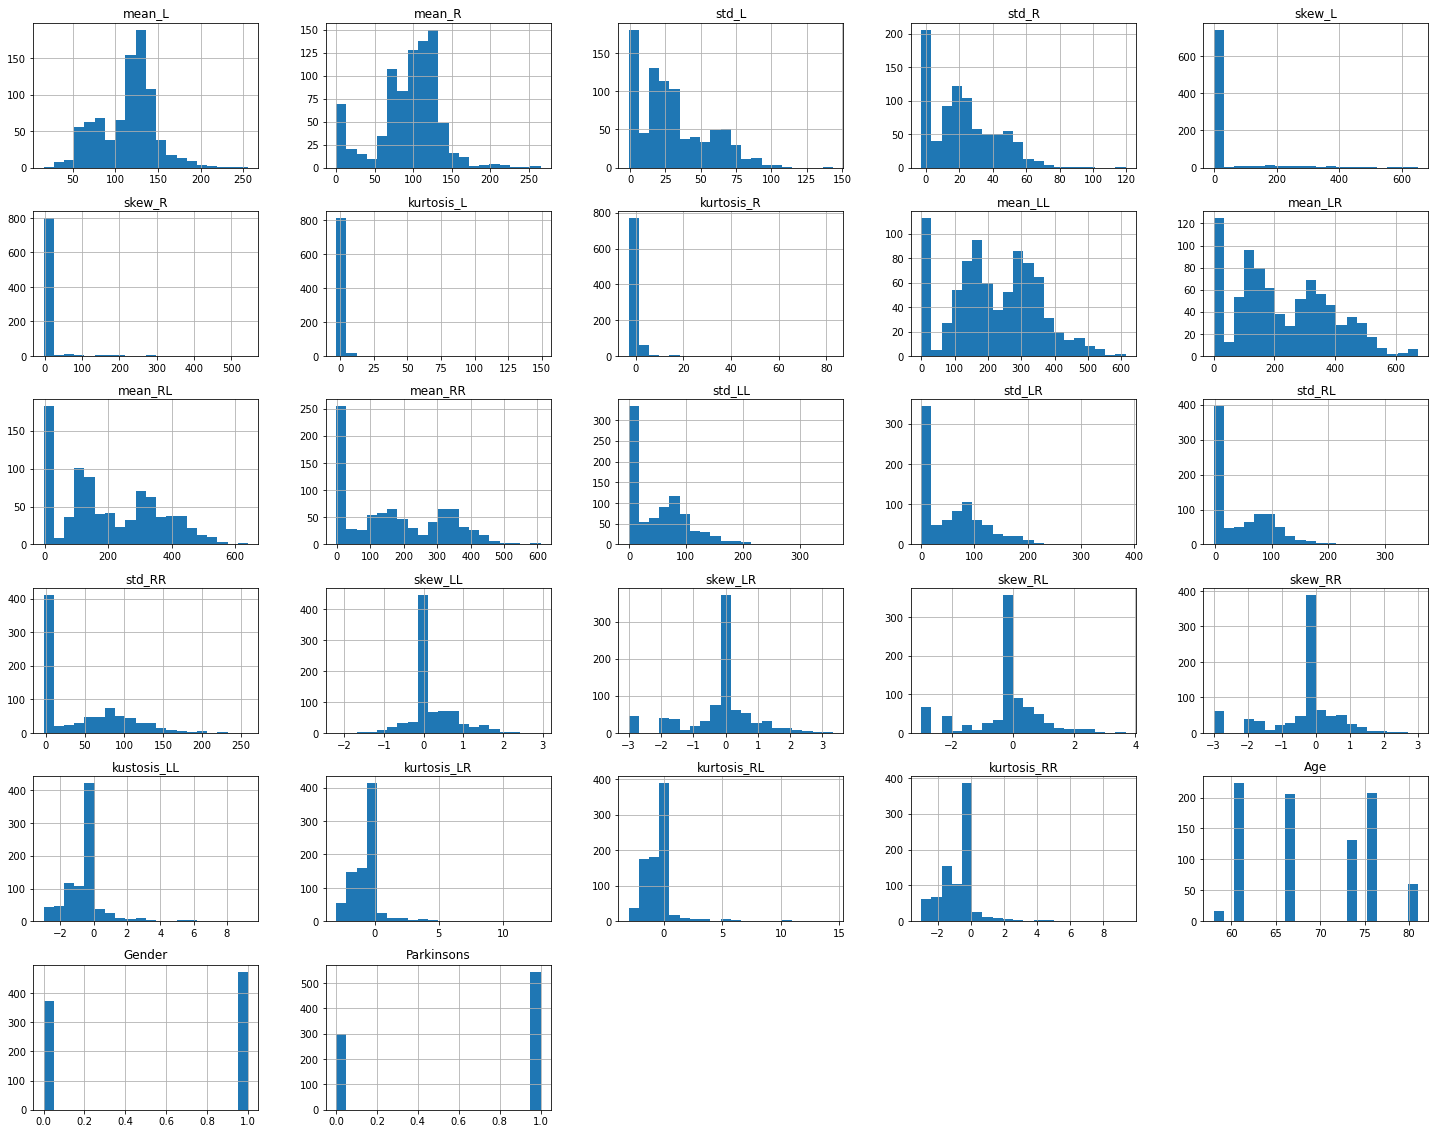

In [36]:
complete_df.hist(bins = 20, figsize=(25,20))
plt.show()

In [16]:
complete_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)
complete_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)
complete_df= complete_df.drop(['Users'],axis = 1)
complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_LL,mean_LR,...,skew_LR,skew_RL,skew_RR,kustosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,Age,Gender,Parkinsons
0,89.471429,114.718182,32.242738,39.047769,-0.996278,0.894344,0.727509,0.715477,343.322222,332.675000,...,0.150590,1.612276,0.014354,-0.884833,-1.440186,2.778230,-1.200129,58,0,0
1,95.710000,99.970370,22.212431,28.162920,0.318459,0.854765,-0.477679,0.866313,352.372414,323.521429,...,0.206801,0.585889,0.732462,-1.123935,-1.126645,0.000542,0.165242,58,0,0
2,85.638889,87.541026,19.892650,15.633882,0.867014,0.050560,4.767066,-0.863455,307.028000,294.488889,...,0.680100,0.386274,-0.005280,0.213010,-0.442493,-0.651916,-0.893680,58,0,0
3,94.374603,99.915152,17.609913,17.646992,0.614686,1.189608,0.436707,1.890580,316.548276,282.689474,...,1.362838,-0.083579,0.619735,0.061265,2.039904,-1.046558,-0.421758,58,0,0
4,100.785000,91.636364,22.656666,11.122524,0.174198,-0.786093,0.000211,-0.420832,366.712500,292.180000,...,1.288881,-0.244349,0.066012,-0.829680,-0.028287,-1.560858,-1.017310,58,0,0


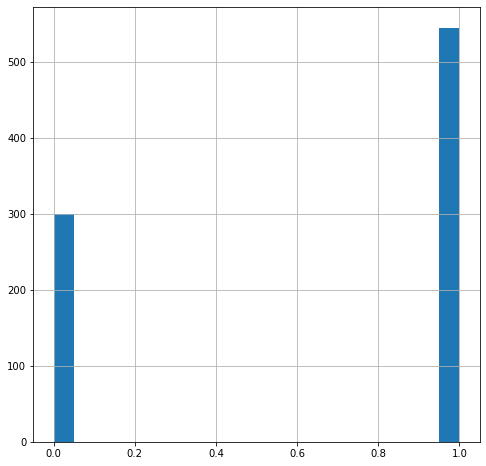

In [37]:
complete_df.Parkinsons.hist(bins=20, figsize=(8, 8))
plt.show()


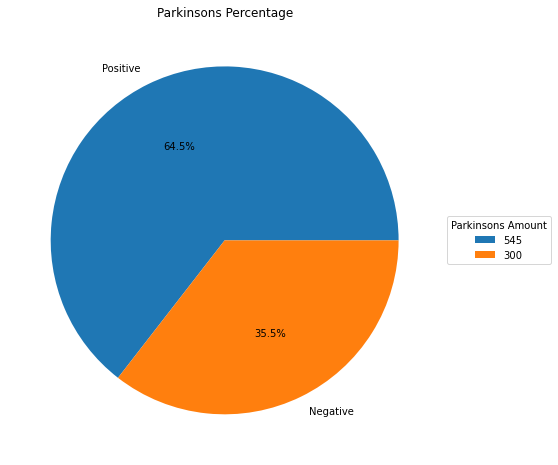

In [18]:
total_rows = complete_df.shape
counts_parkinson = complete_df[complete_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Positive", "Negative"]
plt.figure(figsize=(8,8), facecolor = "white")

plt.pie(x, labels = label, autopct='%1.1f%%')
plt.title("Parkinsons Percentage")
plt.legend(x, title="Parkinsons Amount", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [59]:

# # all_userdata_df.hist(bins = 10, figsize = (20,15), range = [0, 500])
# fig, axs = plt.subplots(1, 5, figsize = (30,5))

# axs[2].hist(all_userdata_df.Hold)
# axs[2].set_title('Hold')
# axs[3].hist(all_userdata_df.Latency)
# axs[3].set_title('Latency')
# axs[1].hist(all_userdata_df.Gender, color = "red")
# axs[1].set_title('Gender')
# axs[0].hist(all_userdata_df.Age)
# axs[0].set_title('Age')
# axs[4].hist(all_userdata_df.Parkinsons, color = "red")
# axs[4].set_title('Parkinsons')

# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==812648.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==84773.4].index, inplace=True)
# # # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==4480.5].index, inplace=True)

# # find = all_userdata_df[all_userdata_df.Hold > 3000]
# # print(find)
"""
complete_df.set_index('Users', inplace = True)

complete_df.head()
"""

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930,406.716242,...,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771,58,0,0
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952,528.670445,...,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816,81,1,0
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
5PQVTWULAC,131.724002,113.398834,37.064749,29.041533,0.978465,-0.062599,7.127388,0.907739,18.325168,358.358252,...,0.611069,2.024448,-0.323100,-0.000415,0.306093,24.435956,-24.794478,74,0,1


In [19]:

x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values

print(x)
print(y)

# ho diviso tutte le colonne (x) dal target parkinsons (y)

[[ 89.47142857 114.71818182  32.24273783 ...  -1.20012881  58.
    0.        ]
 [ 95.71        99.97037037  22.21243124 ...   0.16524211  58.
    0.        ]
 [ 85.63888889  87.54102564  19.89264979 ...  -0.89368022  58.
    0.        ]
 ...
 [145.45       100.26666667  42.8587844  ...  -2.          61.
    0.        ]
 [ 93.8        125.           0.         ...   0.          61.
    0.        ]
 [146.5         46.85        63.55982559 ...   0.          61.
    0.        ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [20]:

# splitto matrice x e array y in sottoinsiemi random di train e test, di dimensioni 4/5 e 1/5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

# graph = all_userdata_df.sample(n = 100)
# x_graph = graph.iloc[:, 1:3].values
# y_graph = graph.iloc[:, -1].values

# print(x_train)
# print(y_train)

# print(x_test)
# print(y_test)

# print(x_graph)
# print(y_graph)


In [21]:
# prima del modello di classificazione faccio lo scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_graph = scaler.fit_transform(x_graph)
#proviamo con questo scaler dopo possiamo provare quello normaliza
# len(x_train) 
# len(x_test) = 316643
# len(x_graph) = 100

In [43]:
# matrice di correlazione per curiosita

# import seaborn as sns
# corr = pd.concat([x, y], axis=1).corr()
# corr_values = corr.iloc[:,15].values
# print("Massima correlazione positiva con il target:", np.max(corr_values[0:corr_values.size-1]))
# print("Massima correlazione negativa con il target:", np.min(corr_values))
# print(pd.concat([x, y], axis=1).columns[abs(corr_values) < 0.01]) 

# plt.figure(figsize=(15, 16), dpi=160)
# sns.heatmap(pd.concat([x, y], axis=1).corr(), cmap="bwr")


In [22]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train)

(830, 26) (830,)
[[ 0.18908555  0.82333434 -0.19187696 ... -0.4016761  -0.38766309
   0.87363104]
 [-0.13001908  0.50499947 -1.01732606 ...  0.47537291  0.64836535
  -1.14464797]
 [-0.20966921 -0.62837732 -1.22677415 ...  0.47537291 -1.27568746
  -1.14464797]
 ...
 [ 0.48554848 -0.27490309  2.31998607 ... -1.03891726 -1.27568746
  -1.14464797]
 [ 0.36477685  0.16895705  1.87134314 ...  0.40630731 -1.27568746
  -1.14464797]
 [ 0.77804794  1.07990926  0.70899877 ... -0.00422636  1.68439378
   0.87363104]]


[1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1
 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1
 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0
 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1
 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0
 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1
 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 

(array([415.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 415.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

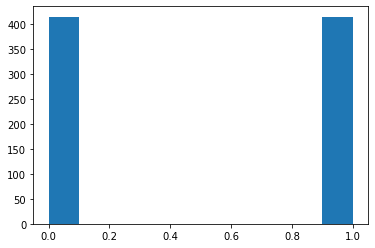

In [23]:
print(y_train)
np.histogram(y_train)
plt.hist(y_train)

0.8795180722891566
0.8773584905660378


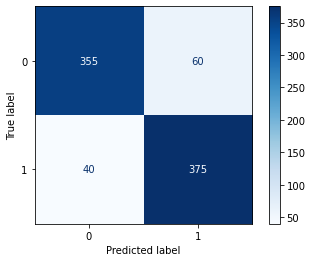

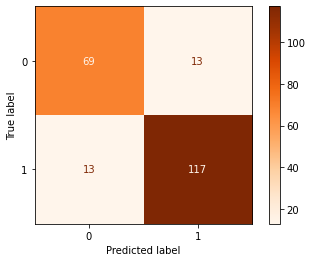

In [24]:
# Naive Bayes classification
classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)



0.9012048192771084
0.8537735849056604


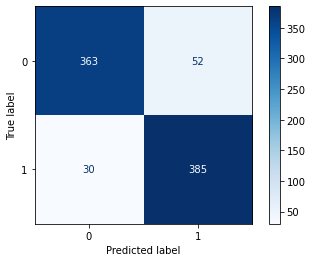

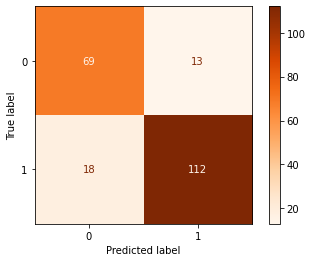

In [25]:

# qua si parte con il learning
# pero il ragazzo di Genova dice che x_train e x_test hanno troppe righe
# allora si riduce le dimensioni del dataset prendendo il 4% (applica test_size = 0.2 per due volte)

#############


classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set
y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

# ogni riga e un'istanza della classe vera
# e la matrice TP FP TN FN
CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()
# print(CM_LogReg)
# print(CM_LogReg0)

# print(PercLogReg)
# print(PercLogReg0)

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#visual
# from matplotlib.colors import ListedColormap

# classifierLogReg_graph = LogisticRegression(random_state = 0)
# classifierLogReg_graph.fit(x_graph, y_graph)

# X_set, y_set = x_graph, y_graph
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                      np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
# plt.figure(1)
# plt.contourf(X1, X2, classifierLogReg_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic Regression')
# plt.xlabel('Latency')
# plt.ylabel('Hold')
# plt.legend()
# plt.show()




1.0
0.9952830188679245


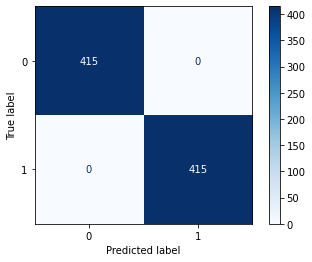

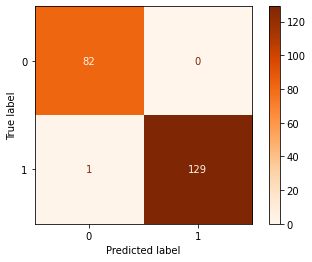

In [26]:
# Decision Tree classification

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


0.9987951807228915
0.9905660377358491


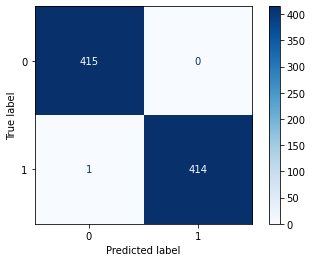

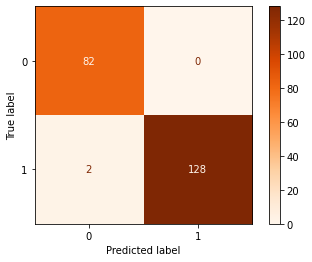

In [27]:
# Random Forest classification

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

0.9879518072289156
0.910377358490566


c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


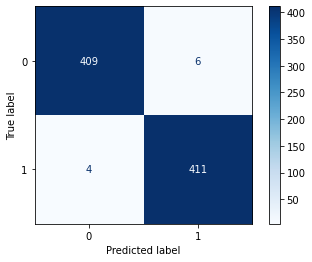

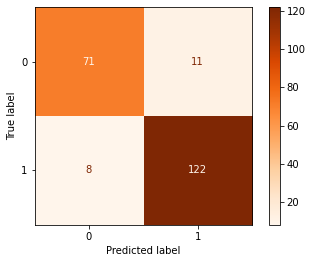

In [38]:
# altri metodi : chi piu ne ha piu ne metta

# Multiple Layer Perceptron
# -------------------------------------------------------------------


classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50) # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50) # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50) # identity act LUI FA CAGARE ATTENZIONE
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50) # logistic act


classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

In [29]:
# ADABOOST v1


classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(x_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.997590 using {'learning_rate': 0.01, 'n_estimators': 200}
0.933735 (0.026166) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.997590 (0.004819) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.997590 (0.004819) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.997590 (0.004819) with: {'learning_rate': 1, 'n_estimators': 200}


0.9951807228915662
0.9669811320754716


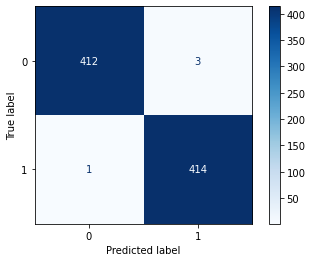

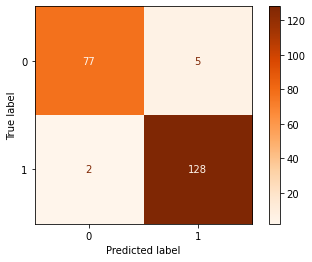

In [30]:
# SVM to fit algorithm

classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

0.9843373493975903
0.9433962264150944


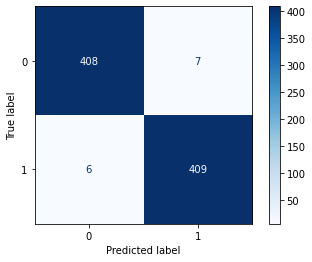

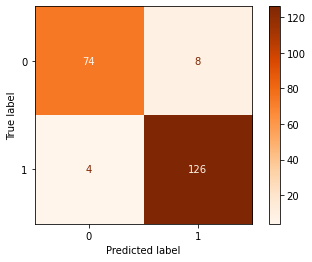

In [31]:
# KNN to fit algorithm

classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

0.9963855421686747
0.9764150943396226


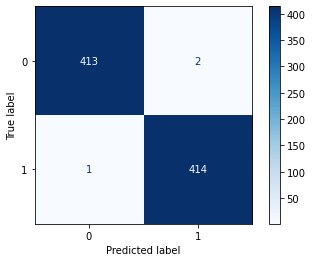

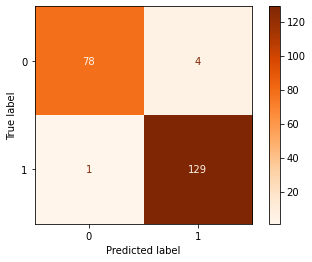

In [32]:
# Ensemble voting

Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))
# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)